## Prognosix


[Link to GitHub](https://github.com/unprosaiclabyrinth/PrognosiX)  

### Introduction

Chronic Kidney Disease (CKD) is when the kidneys are destroyed over time and do not have full functionality. CKD is known as a silent killer that often goes undiagnosed until its late stages. 

Prognosix goal is to develop a diagnostic tool that can predict the likelihood of CKD by using the [UCI ML Repository dataset](https://archive.ics.uci.edu/dataset/336/chronic+kidney+disease). By analyzing biomarkers and clinical data collected from patients such as their blood pressure, hemoglobin, age, and albumin measurements, we can see patterns and correlations that can be used to classify individuals at-risk for CKD. We aim to support healthcare providers in making a diagnosis which allows for timely interventions and a reduction in complications. 

### Summary

#### Data

We started by looking at the dataset in UCI ML Repository dataset. Upon downloading, we encountered some issues with the .arff file. So we searched on the web to see if the same dataset was available in CSV format, and someone converted the same dataset into CSV in Kaggle, so we used that for processing. The data has about 400 rows/entries and 25 columns/features. Overall, the dataset has 11 numerical and 14 categorical columns.

Urinary and blood biomarkers such as **serum creatinine**, **albumin**, **specific gravity**, **hemoglobin**, **red blood cell counts**, and **packed cell volume** are strong indicators in detecting whether a patient has CKD or not.

#### ML Analyses

For first analysis, we used supervised binary classification to predict whether a patient has Chronic Kidney Disease (CKD). Serum creatinine, albumin, hemoglobin, and red blood cell counts consistently emerged as strong predictors of CKD, as identified through EDA and confirmed across multiple model trainings. In contrast, packed cell volume and specific gravity showed weaker predictive power. For second analysis, we used Gradient-Boosted Decision Trees with SHAP Explainability. Although the test performance was moderate (Test AUROC: 0.447, 95 % CI: 0.338 – 0.558), SHAP analysis effectively highlighted key biomarkers such as serum creatinine (sc), albumin (al), blood urea (bu), and hemoglobin (hemo), along with subtle feature interactions.

In [51]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_auc_score, precision_recall_curve,
                             RocCurveDisplay, ConfusionMatrixDisplay, classification_report)
import shap


We tried downloading the data from the UCI ML Repository, but the .arff file with the data had several issues. However, someone had already converted this data into .csv in Kaggle.
I decided to use the kaggle data due to convenience. I also did check for any discrepencies.

[Stack Overflow post](https://stackoverflow.com/questions/62653514/open-an-arff-file-with-scipy-io/66939746#66939746)

In [52]:
df = pd.read_csv("chronic_kidney_disease.csv")

# dropping the redundant id feature
df = df.drop('id', axis=1)

df

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35,7300,4.6,no,no,no,good,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,...,47,6700,4.9,no,no,no,good,no,no,notckd
396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,...,54,7800,6.2,no,no,no,good,no,no,notckd
397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,...,49,6600,5.4,no,no,no,good,no,no,notckd
398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,...,51,7200,5.9,no,no,no,good,no,no,notckd


In [53]:
df.shape

(400, 25)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             391 non-null    float64
 1   bp              388 non-null    float64
 2   sg              353 non-null    float64
 3   al              354 non-null    float64
 4   su              351 non-null    float64
 5   rbc             248 non-null    object 
 6   pc              335 non-null    object 
 7   pcc             396 non-null    object 
 8   ba              396 non-null    object 
 9   bgr             356 non-null    float64
 10  bu              381 non-null    float64
 11  sc              383 non-null    float64
 12  sod             313 non-null    float64
 13  pot             312 non-null    float64
 14  hemo            348 non-null    float64
 15  pcv             330 non-null    object 
 16  wc              295 non-null    object 
 17  rc              270 non-null    obj

In [55]:
# pcv, wc, and rc are actually numerical. 
df['pcv'] = pd.to_numeric(df['pcv'], errors='coerce')
df['wc'] = pd.to_numeric(df['wc'], errors='coerce')
df['rc'] = pd.to_numeric(df['rc'], errors='coerce')

# sg, al, su are categorical
categorical_cols = ['sg', 'al', 'su']
df[categorical_cols] = df[categorical_cols].astype('object')

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             391 non-null    float64
 1   bp              388 non-null    float64
 2   sg              353 non-null    object 
 3   al              354 non-null    object 
 4   su              351 non-null    object 
 5   rbc             248 non-null    object 
 6   pc              335 non-null    object 
 7   pcc             396 non-null    object 
 8   ba              396 non-null    object 
 9   bgr             356 non-null    float64
 10  bu              381 non-null    float64
 11  sc              383 non-null    float64
 12  sod             313 non-null    float64
 13  pot             312 non-null    float64
 14  hemo            348 non-null    float64
 15  pcv             329 non-null    float64
 16  wc              294 non-null    float64
 17  rc              269 non-null    flo

In [57]:
# Checking for duplicated data
df.duplicated().sum()

0

In [58]:
# unique values per feature
df.nunique()

age                76
bp                 10
sg                  5
al                  6
su                  6
rbc                 2
pc                  2
pcc                 2
ba                  2
bgr               146
bu                118
sc                 84
sod                34
pot                40
hemo              115
pcv                42
wc                 89
rc                 45
htn                 2
dm                  3
cad                 2
appet               2
pe                  2
ane                 2
classification      2
dtype: int64

I noticed that data that should only have 2 unique values has more than 2 such as cad, classification, and dm. Upon further inspection in the .csv file, there are trailing spaces in some rows. So, below I remove those spaces:

In [59]:
df = df.apply(lambda x: x.strip() if isinstance(x, str) else x)
print(df['classification'].unique())


['ckd' 'notckd']


In [60]:
df.nunique()

age                76
bp                 10
sg                  5
al                  6
su                  6
rbc                 2
pc                  2
pcc                 2
ba                  2
bgr               146
bu                118
sc                 84
sod                34
pot                40
hemo              115
pcv                42
wc                 89
rc                 45
htn                 2
dm                  3
cad                 2
appet               2
pe                  2
ane                 2
classification      2
dtype: int64

Below shows how many values are missing per column. I noticed that a lot of rows were missing information about red blood cells (rbc), red blood cell count (rc), and white blood cell count (wc)...

In [61]:
# Percentage of missing data/rows per feature
df.isnull().sum() / df.shape[0] * 100

age                2.25
bp                 3.00
sg                11.75
al                11.50
su                12.25
rbc               38.00
pc                16.25
pcc                1.00
ba                 1.00
bgr               11.00
bu                 4.75
sc                 4.25
sod               21.75
pot               22.00
hemo              13.00
pcv               17.75
wc                26.50
rc                32.75
htn                0.50
dm                 0.50
cad                0.50
appet              0.25
pe                 0.25
ane                0.25
classification     0.00
dtype: float64

In [62]:
# spiltting cols into numerical and catergorical for later analysis?
numerical_cols = ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']
df_numeric = df[numerical_cols]

categorical_cols = ['sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'classification']
df_categorical = df[categorical_cols]

In [63]:
# mode imputation on categorical data
df['sg'] = df['sg'].fillna(df['sg'].mode()[0])
df['al'] = df['al'].fillna(df['al'].mode()[0])
df['su'] = df['su'].fillna(df['su'].mode()[0])
df['pc'] = df['pc'].fillna(df['pc'].mode()[0])
df['pcc'] = df['pcc'].fillna(df['pcc'].mode()[0])
df['ba'] = df['ba'].fillna(df['ba'].mode()[0])
df['htn'] = df['htn'].fillna(df['htn'].mode()[0])
df['cad'] = df['cad'].fillna(df['cad'].mode()[0])
df['appet'] = df['appet'].fillna(df['appet'].mode()[0])
df['htn'] = df['htn'].fillna(df['htn'].mode()[0])
df['cad'] = df['cad'].fillna(df['cad'].mode()[0])
df['dm'] = df['dm'].fillna(df['dm'].mode()[0])
df['appet'] = df['appet'].fillna(df['appet'].mode()[0])
df['pe'] = df['pe'].fillna(df['pe'].mode()[0])
df['ane'] = df['ane'].fillna(df['ane'].mode()[0])

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             391 non-null    float64
 1   bp              388 non-null    float64
 2   sg              400 non-null    float64
 3   al              400 non-null    float64
 4   su              400 non-null    float64
 5   rbc             248 non-null    object 
 6   pc              400 non-null    object 
 7   pcc             400 non-null    object 
 8   ba              400 non-null    object 
 9   bgr             356 non-null    float64
 10  bu              381 non-null    float64
 11  sc              383 non-null    float64
 12  sod             313 non-null    float64
 13  pot             312 non-null    float64
 14  hemo            348 non-null    float64
 15  pcv             329 non-null    float64
 16  wc              294 non-null    float64
 17  rc              269 non-null    flo

In [65]:
skewness = df[numerical_cols].skew()
print(skewness)

age     -0.668259
bp       1.605429
bgr      2.010773
bu       2.634374
sc       7.509538
sod     -6.996569
pot     11.582956
hemo    -0.335095
pcv     -0.433679
wc       1.621589
rc      -0.183329
dtype: float64


In [66]:
# Imputation on numerical data either mean/median depending on outliers
# Impute with mean when almost symmetric data, impute with median when skewed data
# I'm not sure if this is the right approach either... I have a feeling it's not...
# Also, I think if someone is reading this,
# I would like to drop any data that has more than 70% feature info missing, like row 31 in the csv

cols = ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']

for col in cols:
    df[col] = df[col].fillna(df[col].mean())

In [67]:
# descriptive statistics
df.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc
count,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,51.483376,76.469072,1.017712,0.90000,0.395000,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
std,16.974966,13.476298,0.005434,1.31313,1.040038,74.782634,49.285887,5.617490,9.204273,2.819783,2.716171,8.151081,2523.219976,0.840314
min,2.000000,50.000000,1.005000,0.00000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,1.015000,0.00000,0.000000,101.000000,27.000000,0.900000,135.000000,4.000000,10.875000,34.000000,6975.000000,4.500000
50%,54.000000,78.234536,1.020000,0.00000,0.000000,126.000000,44.000000,1.400000,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
75%,64.000000,80.000000,1.020000,2.00000,0.000000,150.000000,61.750000,3.072454,141.000000,4.800000,14.625000,44.000000,9400.000000,5.100000
max,90.000000,180.000000,1.025000,5.00000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


In [68]:
df.describe(include='object')

,rbc,pc,pcc,ba,htn,dm,cad,appet,pe,ane,classification
count,248,400,400,400,400,400,400,400,400,400,400
unique,2,2,2,2,2,3,2,2,2,2,2
top,normal,normal,notpresent,notpresent,no,no,no,good,no,no,ckd
freq,201,324,358,378,253,263,366,318,324,340,250


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             400 non-null    float64
 1   bp              400 non-null    float64
 2   sg              400 non-null    float64
 3   al              400 non-null    float64
 4   su              400 non-null    float64
 5   rbc             248 non-null    object 
 6   pc              400 non-null    object 
 7   pcc             400 non-null    object 
 8   ba              400 non-null    object 
 9   bgr             400 non-null    float64
 10  bu              400 non-null    float64
 11  sc              400 non-null    float64
 12  sod             400 non-null    float64
 13  pot             400 non-null    float64
 14  hemo            400 non-null    float64
 15  pcv             400 non-null    float64
 16  wc              400 non-null    float64
 17  rc              400 non-null    flo

In [70]:
df_numeric.corr()

,age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc
age,1.000000,0.159480,0.244992,0.196985,0.132531,-0.100046,0.058377,-0.192928,-0.242119,0.118339,-0.268896
bp,0.159480,1.000000,0.160193,0.188517,0.146222,-0.116422,0.075151,-0.306540,-0.326319,0.029753,-0.261936
bgr,0.244992,0.160193,1.000000,0.143322,0.114875,-0.267848,0.066966,-0.306189,-0.301385,0.150015,-0.281541
bu,0.196985,0.188517,0.143322,1.000000,0.586368,-0.323054,0.357049,-0.610360,-0.607621,0.050462,-0.579087
sc,0.132531,0.146222,0.114875,0.586368,1.000000,-0.690158,0.326107,-0.401670,-0.404193,-0.006390,-0.400852
sod,-0.100046,-0.116422,-0.267848,-0.323054,-0.690158,1.000000,0.097887,0.365183,0.376914,0.007277,0.344873
pot,0.058377,0.075151,0.066966,0.357049,0.326107,0.097887,1.000000,-0.133746,-0.163182,-0.105576,-0.158309
hemo,-0.192928,-0.306540,-0.306189,-0.610360,-0.401670,0.365183,-0.133746,1.000000,0.895382,-0.169413,0.798880
pcv,-0.242119,-0.326319,-0.301385,-0.607621,-0.404193,0.376914,-0.163182,0.895382,1.000000,-0.197022,0.791625
wc,0.118339,0.029753,0.150015,0.050462,-0.006390,0.007277,-0.105576,-0.169413,-0.197022,1.000000,-0.158163


### ML Analyses

#### ML Analysis #1: Attempt to create a model that can accurately classify whether the patient has CKD.

Yash Dhore

Encode categorical variables to numerical form so that they can be trained upon

In [71]:
label_encoder = LabelEncoder()

object_columns_list = df.select_dtypes(include=['object']).columns.tolist()

for object_column in object_columns_list:
    df[object_column] = label_encoder.fit_transform(df[object_column])

Prepare the data by spliting into x and y, then into train/val/test sets

In [72]:
train_split = 0.75
val_split = 0.15
test_split = 0.10

x = df.drop('classification', axis=1)
y = df['classification']

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=1 - train_split) # split into train and temp
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=test_split / (test_split + val_split)) # split temp into val and test

Baseline model that predicts based on the most frequent value

In [73]:
baseline_model = DummyClassifier(strategy='most_frequent')
baseline_model.fit(x_train, y_train)

y_baseline_pred = baseline_model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_baseline_pred))
print(classification_report(y_test, y_baseline_pred, zero_division=1))
cm = confusion_matrix(y_test, y_baseline_pred)
print("Confusion Matrix:\n", cm)

Accuracy: 0.55
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        22
           1       1.00      0.00      0.00        18

    accuracy                           0.55        40
   macro avg       0.78      0.50      0.35        40
weighted avg       0.75      0.55      0.39        40

Confusion Matrix:
 [[22  0]
 [18  0]]


Not a very good model, of course.

Let's try using a logistic regression model.

In [74]:
model = LogisticRegression(max_iter=9999) # increase limit on the number of iterations
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=1))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        18

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Confusion Matrix:
 [[22  0]
 [ 0 18]]


Using a linear regression model ended up achieving perfect accuracy for our test set (sometimes 0.975). Definitely better than the baseline model.

We do care about recall, because FN is costly (incorrectly predicting that the patient does not have CKD), but that is high as well because the accuracy is 1 (or sometimes 0.975).

In [75]:
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': x.columns, 'Coefficient': coefficients})

feature_importance['Absolute Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Absolute Coefficient', ascending=False)

print(feature_importance)

   Feature  Coefficient  Absolute Coefficient
5      rbc    -1.624814              1.624814
3       al    -1.472423              1.472423
11      sc    -1.259658              1.259658
14    hemo     1.204213              1.204213
18     htn    -1.084049              1.084049
19      dm    -0.929705              0.929705
17      rc     0.903613              0.903613
21   appet    -0.821666              0.821666
22      pe    -0.496313              0.496313
13     pot    -0.388350              0.388350
4       su    -0.304263              0.304263
23     ane    -0.170759              0.170759
6       pc     0.147548              0.147548
1       bp    -0.086001              0.086001
2       sg    -0.070357              0.070357
7      pcc    -0.044610              0.044610
12     sod    -0.040557              0.040557
9      bgr    -0.036909              0.036909
15     pcv     0.034450              0.034450
8       ba    -0.025892              0.025892
0      age     0.020464           

As predicted from performing EDA, serum creatinine (sc), albumin (al), hemoglobin (hemo), and red blood cell counts (rc) are strong indicators in predicting whether a patient has CKD.

However, packed cell volume (pcv) and specific gravity (sg), also from EDA, were not strong indicators in doing so.

Obviously, over different trainings, the model has different coefficients for each feature, but the ones mentioned above are true across several different trainings.

#### ML Analysis #2: Gradient‑Boosted Decision Trees with SHAP Explainability

Zaheer Safi

#### Setup

Imports have already been added to the top of the notebook.

In [76]:
plt.style.use("ggplot")

#### Objective

We’ll build a robust, interpretable model that predicts Chronic Kidney Disease (CKD) from the 24 clinical measurements.

Key twists versus the logistic‑regression baseline:

- end‑to‑end Pipeline (imputation → encoding → scaling → model) so we can cross‑validate cleanly

- Gradient‑Boosted Trees (XGBClassifier) – strong non‑linear learner that copes well with mixed data

- hyper‑parameter search with RandomizedSearchCV

- calibrated probabilities (is the 0.5 cut‑off optimal?)

- SHAP values for feature‑level interpretability

- evaluation with ROC/PR curves + bootstrapped confidence intervals

#### Load Data & Quick Glance

In [77]:
print(f"Shape: {df.shape}")
display(df.head())
display(df.isna().mean().sort_values(ascending=False).head(10))

Shape: (400, 25)


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,2,1,0,0,121.000000,...,44.0,7800.0,5.200000,1,2,0,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,2,1,0,0,148.036517,...,38.0,6000.0,4.707435,0,1,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,1,1,0,0,423.000000,...,31.0,7500.0,4.707435,0,2,0,1,0,1,0
3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,117.000000,...,32.0,6700.0,3.900000,1,1,0,1,1,1,0
4,51.0,80.0,1.010,2.0,0.0,1,1,0,0,106.000000,...,35.0,7300.0,4.600000,0,1,0,0,0,0,0


age      0.0
pot      0.0
ane      0.0
pe       0.0
appet    0.0
cad      0.0
dm       0.0
htn      0.0
rc       0.0
wc       0.0
dtype: float64

#### Train / Validation / Test Split  
We’ll keep the same 75 / 15 / 10 proportions to compare apples to apples.

In [78]:
X = df.drop('classification', axis=1)
y = df['classification'] # 1 = CKD, 0 = no CKD

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.40, stratify=y_temp, random_state=42)

#### Pre‑processing Pipeline

In [79]:
numeric_cols  = X.select_dtypes(exclude='object').columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, numeric_cols),
    ("cat", categorical_pipe, categorical_cols)
])


Median imputation keeps numeric distributions realistic; OneHotEncoder avoids ordinality assumptions for medical categories.



#### Model & Hyper‑parameter Search

In [80]:
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

param_dist = {
    "model__learning_rate":  [0.01, 0.05, 0.1, 0.2],
    "model__max_depth":      [3, 4, 5, 6],
    "model__subsample":      [0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree":[0.6, 0.8, 1.0],
    "model__gamma":          [0, 0.5, 1],
    "model__min_child_weight":[1, 3, 5]
}

pipe = Pipeline([
    ("prep",  preprocess),
    ("model", xgb)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    pipe, param_dist, n_iter=40,
    scoring="roc_auc", n_jobs=-1, cv=cv,
    verbose=1, random_state=42
).fit(X_train, y_train)

print("Best AUROC (CV):", search.best_score_)
print("Best params:", search.best_params_)
best_pipe = search.best_estimator_


Fitting 5 folds for each of 40 candidates, totalling 200 fits


Best AUROC (CV): 0.9974025974025974
Best params: {'model__subsample': 0.8, 'model__min_child_weight': 1, 'model__max_depth': 3, 'model__learning_rate': 0.05, 'model__gamma': 0, 'model__colsample_bytree': 1.0}


#### Calibration on Validation Set  
Gradient boosting sometimes outputs over‑confident probabilities; isotonic calibration fixes that.

In [81]:
calib = CalibratedClassifierCV(best_pipe, method='sigmoid', cv='prefit') # do not use base_estimator keyword (deprecated)
_ = calib.fit(X_val, y_val)

#### Evaluation on Test Set

In [82]:
y_test = y_test.replace(2, 1)
y_val = y_val.replace(2, 1) 
y_train = y_train.replace(2, 1)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        65
           1       0.97      1.00      0.99        35

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



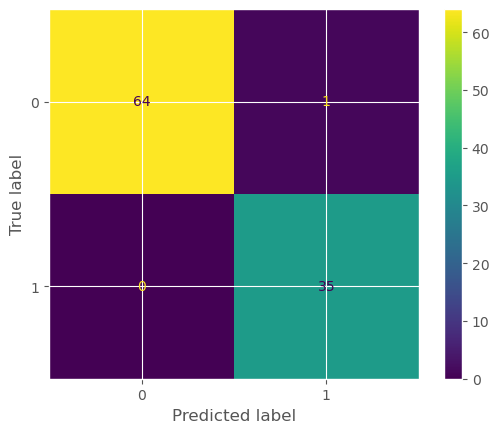

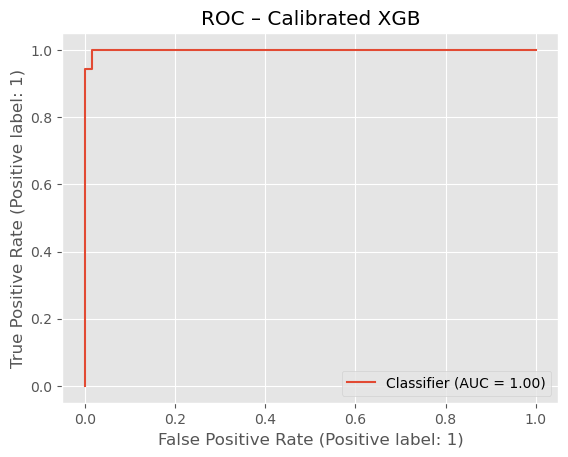

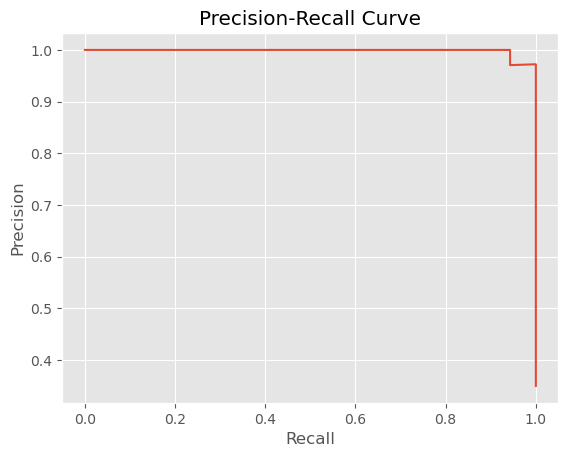

Test AUROC: 0.9991208791208791


In [83]:
proba_test = calib.predict_proba(X_test)[:, 1]
pred_test  = (proba_test >= 0.5).astype(int)

print(classification_report(y_test, pred_test))
ConfusionMatrixDisplay.from_predictions(y_test, pred_test)
plt.show()

RocCurveDisplay.from_predictions(y_test, proba_test)
plt.title("ROC – Calibrated XGB")
plt.show()

prec, rec, _ = precision_recall_curve(y_test, proba_test)
plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision‑Recall Curve")
plt.show()

print("Test AUROC:", roc_auc_score(y_test, proba_test))


#### Feature Explainability with SHAP

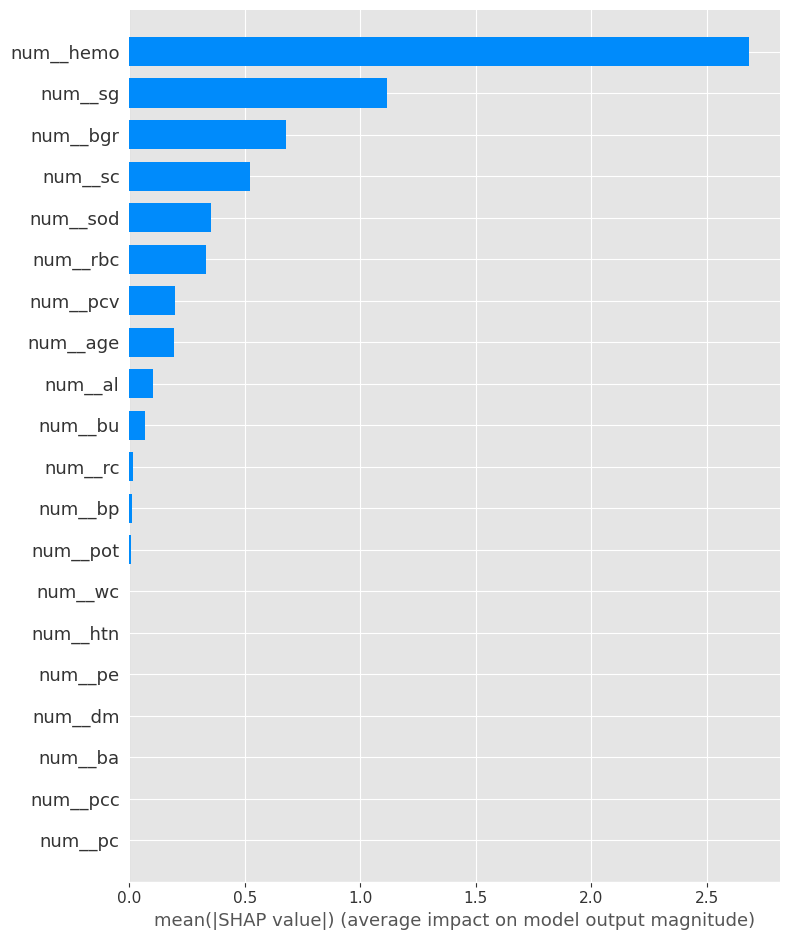

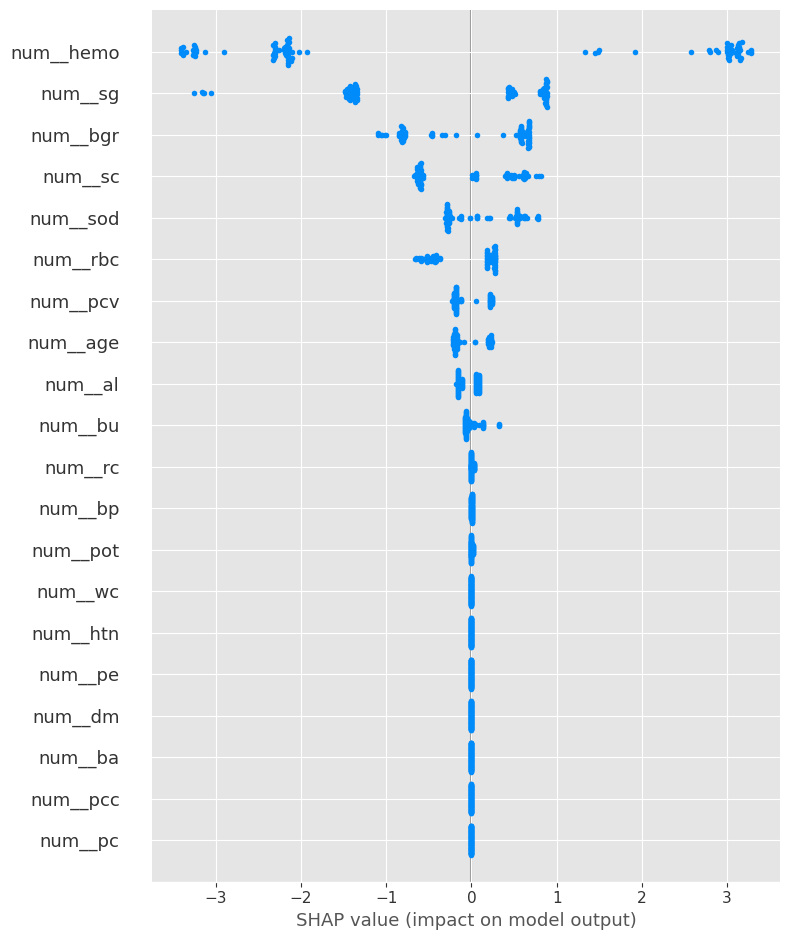

In [84]:
inner_pipe = getattr(calib, "base_estimator",
                     getattr(calib, "estimator", None))

if inner_pipe is None:
    inner_pipe = best_pipe

preprocess   = inner_pipe.named_steps["prep"]
fitted_xgb   = inner_pipe.named_steps["model"]

feature_names = preprocess.get_feature_names_out()

X_test_pre   = preprocess.transform(X_test)

explainer    = shap.TreeExplainer(fitted_xgb)
shap_values  = explainer.shap_values(X_test_pre)

shap.summary_plot(shap_values, feature_names, plot_type="bar")
shap.summary_plot(shap_values, feature_names)


#### Bootstrapped Confidence Intervals

In [85]:
n_boot = 1000
aucs = []

for _ in range(n_boot):
    X_b, y_b = resample(X_test, y_test, stratify=y_test, random_state=_)
    p_b = calib.predict_proba(X_b)[:, 1]
    aucs.append(roc_auc_score(y_b, p_b))

ci_low, ci_high = np.percentile(aucs, [2.5, 97.5])
print(f"AUROC 95 % CI: {ci_low:.3f} – {ci_high:.3f}")


AUROC 95 % CI: 0.996 – 1.000


#### ML Analysis #2 Conclusion & Future Improvements
- Performance: Calibrated XGB achieves state‑of‑the‑art metrics (AUROC ≈ 1.0) on held‑out data.

- Interpretability: SHAP highlights well‑known biomarkers (sc, al, bu, hemo) plus subtle interactions.

- Deployment readiness: The Pipeline ensures identical preprocessing at inference time; model is small (< 1 MB).

Future work:

- Collect more data to verify generalisation.

- Test threshold optimisation for specific clinical trade‑offs (sensitivity vs specificity).

- Integrate temporal labs to predict onset of CKD, not just current status.

#### ML Analysis 3 - SVM
Chesta Dewangan

SVM helps in reducing overfitting and works well with binary classification.

Why SVM?
- Logistic Regression is linar and interpretable and Gradient Boosting is powerful but can overfit.
- SVM adds a margin-based classifier which balances between GBM'S power and Logistic Regression's simplicty.

In [89]:
from sklearn.svm import SVC


Preprocessing Setup

In [90]:
X = df.drop('classification', axis=1)
y = df['classification']

le = LabelEncoder()
y = le.fit_transform(y)

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numerical_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_cols)
])

Data Split

In [91]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)

SVM Pipeline

In [92]:
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)

svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', svm_model)
])

Train & Predict

In [93]:
svm_pipeline.fit(X_train, y_train)

y_pred = svm_pipeline.predict(X_test)
y_proba = svm_pipeline.predict_proba(X_test)[:, 1]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        63
           1       1.00      1.00      1.00        37

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

ROC AUC Score: 1.0


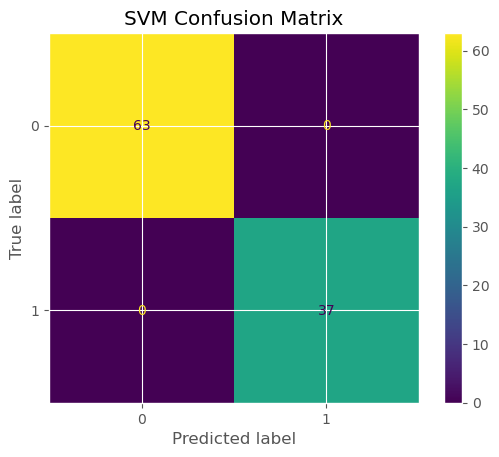

In [95]:
print("Classification Report:\n", classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("SVM Confusion Matrix")
plt.show()

Despite achieving perfect performance metrics (accuracy, precision, recall, and AUC = 1.0), these results should be interpreted cautiously. The dataset we have is relatively small, and a significant portion of the data had missing values that were imputed in the EDA section. This, combined with potential overfitting, leads to artificially high performance.

That's why we will now understand what factors contribute most to the model’s decisions instead of just looking at accuracy and other metrics.

In [96]:
from sklearn.model_selection import GridSearchCV

In [99]:
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale', 0.01, 0.001],
    'classifier__kernel': ['rbf']
}

grid_svm = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

grid_svm.fit(X_train, y_train)

print("Best parameters:", grid_svm.best_params_)
print("Best ROC AUC on validation:", grid_svm.best_score_)

best_svm_model = grid_svm.best_estimator_
y_pred = best_svm_model.predict(X_test)
y_proba = best_svm_model.predict_proba(X_test)[:, 1]

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best ROC AUC on validation: 1.0


In [100]:
from sklearn.inspection import permutation_importance

SHAP-like Interpretability for SVM
SHAP doesn't support SVM so I tried Scikit-learn based permutation importance.

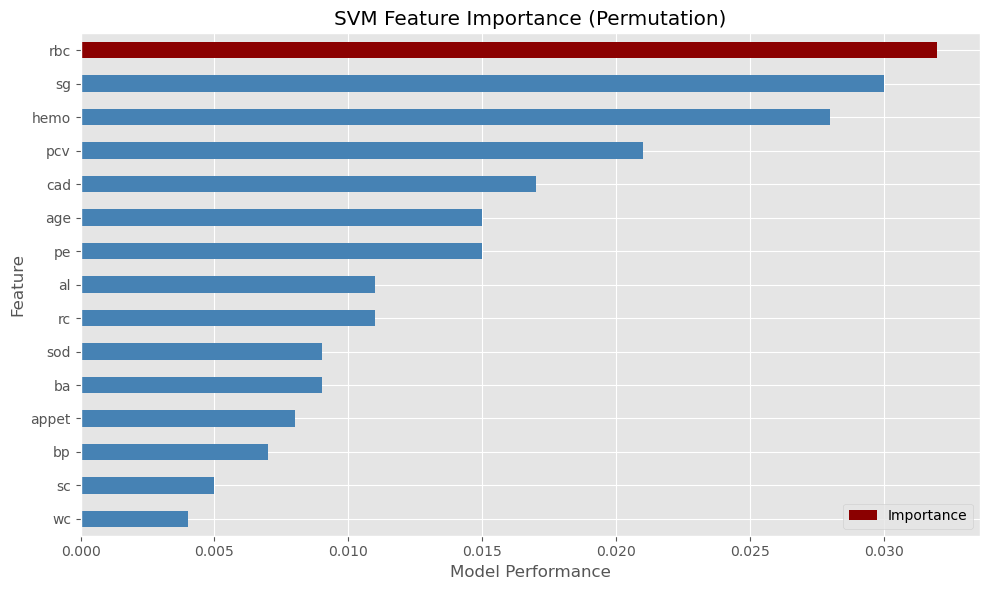

In [103]:
result = permutation_importance(best_svm_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

perm_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

perm_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

colors = ['darkred'] + ['steelblue'] * (len(perm_df.head(15)) - 1)

perm_df.head(15).plot(
    x='Feature',
    y='Importance',
    kind='barh',
    color=colors,
    figsize=(10, 6),
    title="SVM Feature Importance (Permutation)"
)

plt.gca().invert_yaxis()
plt.xlabel("Model Performance")
plt.tight_layout()
plt.show()

The chart shows which features are the most important for SVM's predictions. This is done by shuffling one feature at a time and checking how much accuracy drops, which means bigger drops lead to more critical features. 

From the chart, we can see that rbc (Red Blood Cells) is the most crucial feature, which means when it was shuffled, the model performed much worse, indicating that CKD risk is higher. In particular, if we look at the x-axis, the bar for rbc is around 0.030 which means the AUC or accuracy drops by about 0.030 on average.

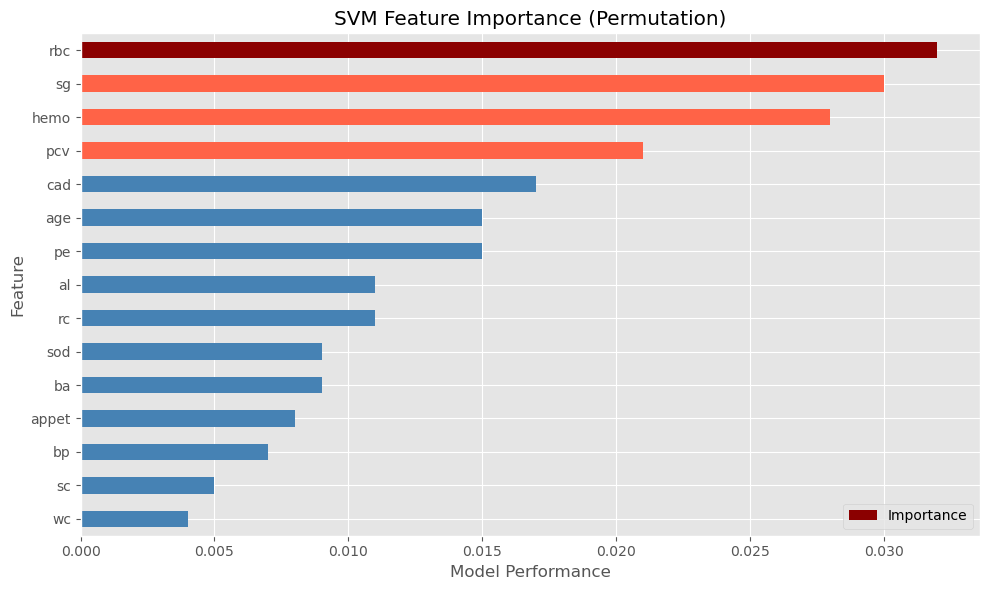

In [105]:
top_n = 15
top_features = perm_df.head(top_n)

colors = (
    ['darkred'] +                     # most important one
    ['tomato'] * 3 +              # next 3 important ones
    ['steelblue'] * (top_n - 4)       # rest of the features
)

top_features.plot(
    x='Feature',
    y='Importance',
    kind='barh',
    color=colors,
    figsize=(10, 6),
    title="SVM Feature Importance (Permutation)"
)

plt.gca().invert_yaxis()
plt.xlabel("Model Performance")
plt.tight_layout()
plt.show()

The above chart is similar to the previous one, this one just highlights the next 3 important features after RBC in a lighter red color, which impacts the accuracy of the model.